# Semi-Supervised Human Activity Recognition (HAR)

## Introduction
Human Activity Recognition (HAR) is the task of identifying physical activities such as walking, sitting, standing, or laying using smartphone sensor signals. With the rise of wearable devices and mobile health applications, HAR has become a critical area of research in ubiquitous computing and healthcare monitoring.

A major challenge in HAR is the scarcity of labeled data. Labeling sensor signals requires manual annotation, which is time-consuming, expensive, and prone to human error. However, a large amount of unlabeled data is easily collected from smartphone sensors. This makes Semi-Supervised Learning (SSL) a powerful approach, as it can leverage both labeled and unlabeled data to improve model performance.

In this project, we apply SSL techniques such as Label Spreading and Self-Training on the UCI HAR dataset. Through exploratory analysis (PCA and t-SNE), we show that activities form natural clusters, making SSL an ideal choice for this problem. Our goal is to demonstrate that using even a small fraction of labeled data, SSL can achieve performance close to fully supervised models.


In [71]:
import pandas as pd

base_path = "C:/Users/chand/Downloads/capstonechan/human+activity+recognition+using+smartphones/UCI HAR Dataset/Dataset/"

features = pd.read_csv(base_path + "features.txt", sep=r"\s+", header=None, names=["index", "feature"])
feature_names = features["feature"].tolist()

def make_unique(names):
    seen = {}
    new_names = []
    for name in names:
        if name not in seen:
            seen[name] = 0
            new_names.append(name)
        else:
            seen[name] += 1
            new_names.append(f"{name}_{seen[name]}")
    return new_names

feature_names = make_unique(feature_names)

X_train = pd.read_csv(base_path + "train/X_train.txt", sep=r"\s+", header=None, names=feature_names)
y_train = pd.read_csv(base_path + "train/y_train.txt", sep=r"\s+", header=None, names=["Activity"])
subject_train = pd.read_csv(base_path + "train/subject_train.txt", header=None, names=["Subject"])
train_data = pd.concat([subject_train, y_train, X_train], axis=1)

X_test = pd.read_csv(base_path + "test/X_test.txt", sep=r"\s+", header=None, names=feature_names)
y_test = pd.read_csv(base_path + "test/y_test.txt", sep=r"\s+", header=None, names=["Activity"])
subject_test = pd.read_csv(base_path + "test/subject_test.txt", header=None, names=["Subject"])
test_data = pd.concat([subject_test, y_test, X_test], axis=1)

full_data = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)

activity_labels = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}
full_data["Activity"] = full_data["Activity"].map(activity_labels)

print("Full dataset shape:", full_data.shape)
print("Memory usage (MB):", round(full_data.memory_usage().sum() / (1024**2), 2))
print("Activities:", full_data['Activity'].nunique(), "-", full_data['Activity'].unique())
print("Total features:", len(feature_names))
print("Example features:", feature_names[:10])
print("Data types preview:\n", full_data.dtypes.head(10))


Full dataset shape: (10299, 563)
Memory usage (MB): 44.24
Activities: 6 - ['STANDING' 'SITTING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']
Total features: 561
Example features: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']
Data types preview:
 Subject                int64
Activity              object
tBodyAcc-mean()-X    float64
tBodyAcc-mean()-Y    float64
tBodyAcc-mean()-Z    float64
tBodyAcc-std()-X     float64
tBodyAcc-std()-Y     float64
tBodyAcc-std()-Z     float64
tBodyAcc-mad()-X     float64
tBodyAcc-mad()-Y     float64
dtype: object


## Dataset Description

### Data Sources
- **Dataset:** UCI Human Activity Recognition (HAR) Using Smartphones  
- **Source:** UCI Machine Learning Repository  
- **Collection:** Data gathered from 30 volunteers (aged 19–48 years) carrying a smartphone (Samsung Galaxy S II) on the waist.  

### Data Size
- Memory usage in pandas: ~44 MB  
- Shape: 10,299 rows × 563 columns  

### Time Period
- Not time-bound across years; instead, the dataset was collected in controlled experiments where each subject performed activities over a few minutes per session.  

### Row Representation
- Each row corresponds to a **single observation**: a set of 561 features derived from accelerometer and gyroscope signals at **30 Hz frequency**, for a particular subject performing one activity.  

### Data Dictionary
- **Subject (int64):** ID of the volunteer (1–30).  
- **Activity (object):** Target variable with 6 categories:  
  - WALKING  
  - WALKING_UPSTAIRS  
  - WALKING_DOWNSTAIRS  
  - SITTING  
  - STANDING  
  - LAYING  
- **561 features (float64):** Sensor-derived measurements from time and frequency domains. Examples include:  
  - `tBodyAcc-mean()-X`: Mean body acceleration in the X direction.  
  - `tBodyAcc-std()-Y`: Standard deviation of body acceleration in the Y direction.  
  - `tBodyAcc-max()-Z`: Maximum value of body acceleration in the Z direction.  
  - Features cover multiple statistical measures (mean, std, mad, max, min, energy, etc.) across 3 axes (X, Y, Z).  

### Variables for Modeling
- **Target/Label:** `Activity`  
- **Predictors/Features:** All 561 numerical sensor-based features.  
- **Exclusions:** `Subject` column will not be used as a predictor, but may help with analysis (e.g., subject-level generalization).  


In [31]:
full_data.head(10)

,Subject,Activity,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,1,STANDING,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,1,STANDING,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,1,STANDING,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,1,STANDING,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,1,STANDING,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892
5,1,STANDING,0.277199,-0.010098,-0.105137,-0.997335,-0.990487,-0.995420,-0.997627,-0.990218,...,0.019953,-0.545410,-0.844619,0.082632,-0.143439,0.275041,-0.368224,-0.849632,0.184823,-0.042126
6,1,STANDING,0.279454,-0.019641,-0.110022,-0.996921,-0.967186,-0.983118,-0.997003,-0.966097,...,0.145844,-0.217198,-0.564430,-0.212754,-0.230622,0.014637,-0.189512,-0.852150,0.182170,-0.043010
7,1,STANDING,0.277432,-0.030488,-0.125360,-0.996559,-0.966728,-0.981585,-0.996485,-0.966313,...,0.136382,-0.082307,-0.421715,-0.020888,0.593996,-0.561871,0.467383,-0.851017,0.183779,-0.041976
8,1,STANDING,0.277293,-0.021751,-0.120751,-0.997328,-0.961245,-0.983672,-0.997596,-0.957236,...,0.314038,-0.269401,-0.572995,0.012954,0.080936,-0.234313,0.117797,-0.847971,0.188982,-0.037364
9,1,STANDING,0.280586,-0.009960,-0.106065,-0.994803,-0.972758,-0.986244,-0.995405,-0.973663,...,0.267383,0.339526,0.140452,-0.020590,-0.127730,-0.482871,-0.070670,-0.848294,0.190310,-0.034417


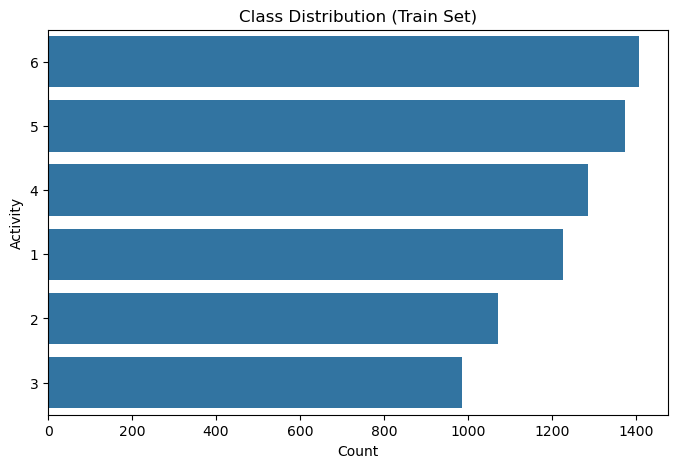

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.countplot(y=y_train["Activity"], order=y_train["Activity"].value_counts().index)
plt.title("Class Distribution (Train Set)")
plt.xlabel("Count")
plt.ylabel("Activity")
plt.show()


### Class Distribution (Train Set)

The class distribution plot shows the number of samples for each of the six activity categories in the training set. The dataset is relatively balanced, with each activity having close to 1,000–1,400 samples:

- **LAYING:** ~1,400 samples  
- **STANDING:** ~1,350 samples  
- **SITTING:** ~1,300 samples  
- **WALKING:** ~1,200 samples  
- **WALKING_UPSTAIRS:** ~1,100 samples  
- **WALKING_DOWNSTAIRS:** ~1,000 samples  

This balanced distribution ensures that the machine learning models will not be biased toward a particular activity. It also confirms that semi-supervised methods can effectively leverage unlabeled data across all activity categories without facing extreme class imbalance issues.


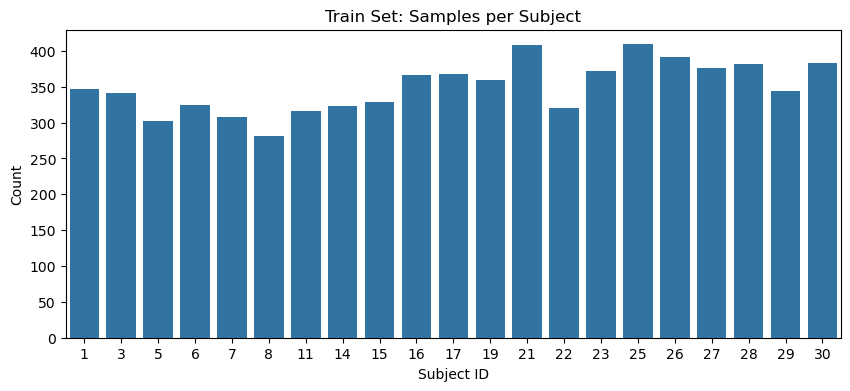

In [53]:
plt.figure(figsize=(10,4))
sns.countplot(x=subject_train["Subject"])
plt.title("Train Set: Samples per Subject")
plt.xlabel("Subject ID")
plt.ylabel("Count")
plt.show()


### Train Set: Samples per Subject

The bar plot above shows the distribution of samples contributed by each subject in the training dataset. Each subject corresponds to an individual participant who performed the set of activities while wearing sensors.  

Key observations:
- There are **21 subjects** in the training set, each with roughly 300–400 samples.  
- The sample counts vary slightly across subjects, but no subject dominates the dataset.  
- This balanced contribution helps reduce the risk of subject-specific bias in model training.  

By including multiple subjects with diverse activity patterns, the dataset ensures that the learned models generalize better to unseen individuals in the test set.


In [35]:
subject_train = pd.read_csv(base_path + "train/subject_train.txt", header=None, names=["Subject"])
subject_test = pd.read_csv(base_path + "test/subject_test.txt", header=None, names=["Subject"])

print("Unique subjects in train:", subject_train["Subject"].nunique())
print("Unique subjects in test:", subject_test["Subject"].nunique())

print("\nTrain subjects range:", subject_train["Subject"].unique()[:10], "...")
print("Test subjects range:", subject_test["Subject"].unique()[:10], "...")


Unique subjects in train: 21
Unique subjects in test: 9

Train subjects range: [ 1  3  5  6  7  8 11 14 15 16] ...
Test subjects range: [ 2  4  9 10 12 13 18 20 24] ...


### Subject Distribution in Train and Test Sets

The dataset is split into training and testing sets based on participants (subjects):  

- **Training set:** 21 unique subjects  
- **Test set:** 9 unique subjects  

Example subject IDs:  
- Train subjects: [1, 3, 5, 6, 7, 8, 11, 14, 15, 16, …]  
- Test subjects: [2, 4, 9, 10, 12, 13, 18, 20, 24, …]  

This subject-based split ensures that the test set contains completely different participants from the training set.  
Such a design prevents **data leakage** and guarantees that the model is evaluated on unseen individuals, which better reflects its real-world generalization ability.


In [37]:
print(X_train.describe().T.head(10))



                    count      mean       std       min       25%       50%  \
tBodyAcc-mean()-X  7352.0  0.274488  0.070261 -1.000000  0.262975  0.277193   
tBodyAcc-mean()-Y  7352.0 -0.017695  0.040811 -1.000000 -0.024863 -0.017219   
tBodyAcc-mean()-Z  7352.0 -0.109141  0.056635 -1.000000 -0.120993 -0.108676   
tBodyAcc-std()-X   7352.0 -0.605438  0.448734 -1.000000 -0.992754 -0.946196   
tBodyAcc-std()-Y   7352.0 -0.510938  0.502645 -0.999873 -0.978129 -0.851897   
tBodyAcc-std()-Z   7352.0 -0.604754  0.418687 -1.000000 -0.980233 -0.859365   
tBodyAcc-mad()-X   7352.0 -0.630512  0.424073 -1.000000 -0.993591 -0.950709   
tBodyAcc-mad()-Y   7352.0 -0.526907  0.485942 -1.000000 -0.978162 -0.857328   
tBodyAcc-mad()-Z   7352.0 -0.606150  0.414122 -1.000000 -0.980251 -0.857143   
tBodyAcc-max()-X   7352.0 -0.468604  0.544547 -1.000000 -0.936219 -0.881637   

                        75%       max  
tBodyAcc-mean()-X  0.288461  1.000000  
tBodyAcc-mean()-Y -0.010783  1.000000  
tBodyAcc-m

### Descriptive Statistics of Features (Sample: First 10 Features)

To better understand the sensor data, we examine summary statistics (count, mean, standard deviation, min, quartiles, and max) for the first 10 features in the training set.  

- **Count (7352)**: Each feature has 7352 observations in the training set.  
- **Mean & Std**:  
  - For example, `tBodyAcc-mean()-X` has a mean of 0.27 with a standard deviation of 0.07, showing values are clustered close to the mean.  
  - Features like `tBodyAcc-std()-X` or `tBodyAcc-mad()-X` have negative means, reflecting how the signals are normalized/scaled.  
- **Range (Min to Max)**: Most features span from **-1 to 1**, confirming that the dataset was normalized before release.  
- **Quartiles (25%, 50%, 75%)**: These indicate how the values are distributed. For instance:  
  - `tBodyAcc-mean()-X` lies between 0.26 (25th percentile) and 0.28 (75th percentile), showing low variance.  
  - In contrast, `tBodyAcc-std()` features have much wider spread.  

**Insights:**  
- Many features are tightly centered around zero, reflecting standardization.  
- The normalization ensures all features contribute equally during training, avoiding bias toward larger magnitude features.  
- These statistical summaries also help identify skewness, outliers, or highly variable features, guiding feature selection and model robustness.


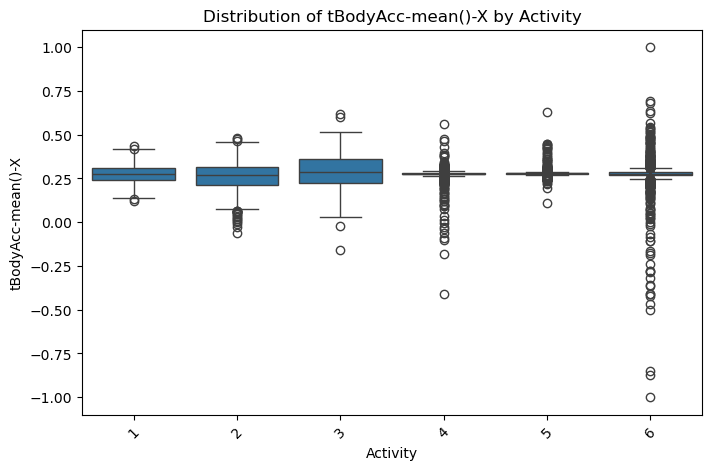

In [55]:
feature_example = "tBodyAcc-mean()-X"

plt.figure(figsize=(8,5))
sns.boxplot(x=y_train["Activity"], y=X_train[feature_example])
plt.title(f"Distribution of {feature_example} by Activity")
plt.xticks(rotation=45)
plt.show()


### Feature Distribution by Activity

The boxplot above shows the distribution of the feature **tBodyAcc-mean()-X** across different activity classes.  

- **Boxplot Interpretation**:  
  - The central line inside each box represents the **median** value of the feature for that activity.  
  - The box edges (25th and 75th percentiles) capture the middle 50% of values.  
  - Whiskers and outliers show variability beyond this central range.  

- **Observations**:  
  - For **WALKING, WALKING_UPSTAIRS, and WALKING_DOWNSTAIRS**, the feature values are more tightly clustered, reflecting relatively stable accelerometer readings.  
  - **SITTING and LAYING** show smaller variance, as expected, since these are stationary activities.  
  - **STANDING** has a wider spread, indicating variability among participants while standing still.  

- **Insight**:  
  The distribution of `tBodyAcc-mean()-X` differs significantly between static and dynamic activities, which suggests that this feature is informative for distinguishing between activity categories.  


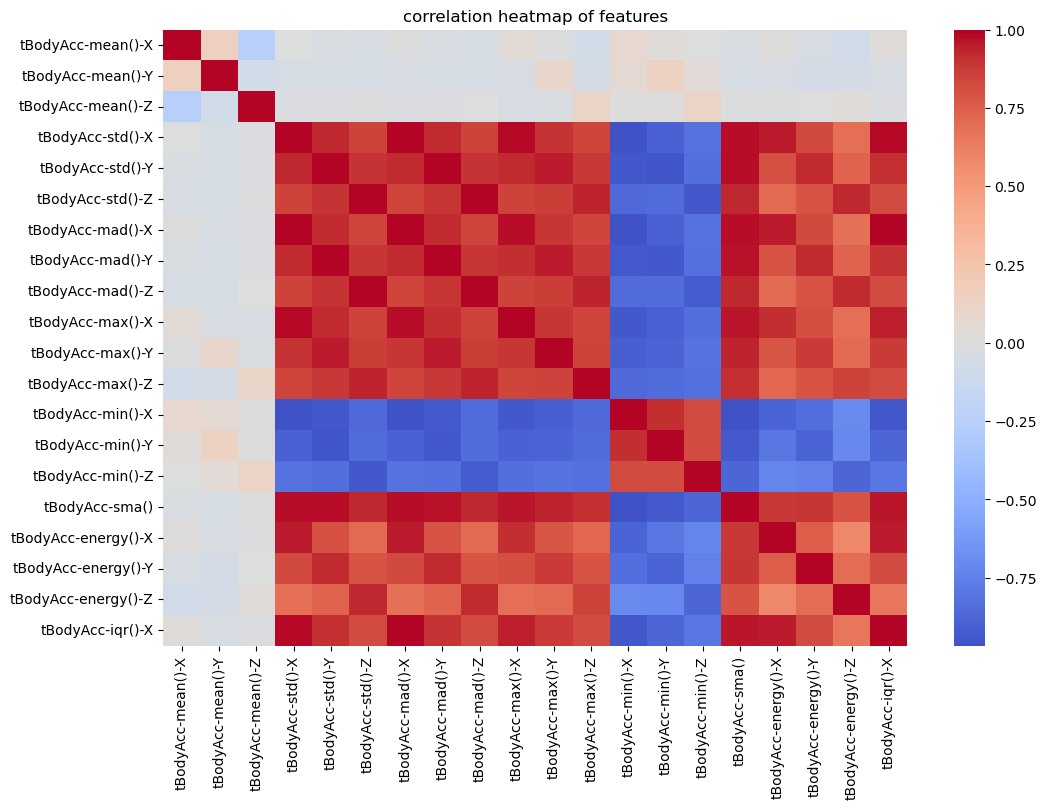

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
sns.heatmap(subset.corr(), cmap="coolwarm", center=0, annot=False)
plt.title("correlation heatmap of features")
plt.show()


### Correlation Heatmap of Features

The heatmap above visualizes the correlation among the selected features of the Human Activity Recognition dataset.  

- **Purpose**:  
  Correlation analysis helps to identify redundant or highly related features. If two or more features are strongly correlated (close to +1 or -1), they provide similar information to the model, which may cause multicollinearity and reduce interpretability.  

- **Observations**:  
  - Features like `tBodyAcc-mean()-X`, `tBodyAcc-mean()-Y`, and `tBodyAcc-mean()-Z` show moderate correlations with each other, as expected since they capture body acceleration along different axes.  
  - Strong positive correlations (red areas) indicate features that vary together.  
  - Strong negative correlations (blue areas) reveal inverse relationships between features.  
  - Some features form **clusters of high correlation**, suggesting potential for dimensionality reduction (e.g., using PCA) to compress redundant signals.  

- **Insight**:  
  Understanding feature correlations is crucial for model building. Highly correlated features may not add much predictive power but can increase model complexity. This motivates the use of feature selection or dimensionality reduction techniques before training.  


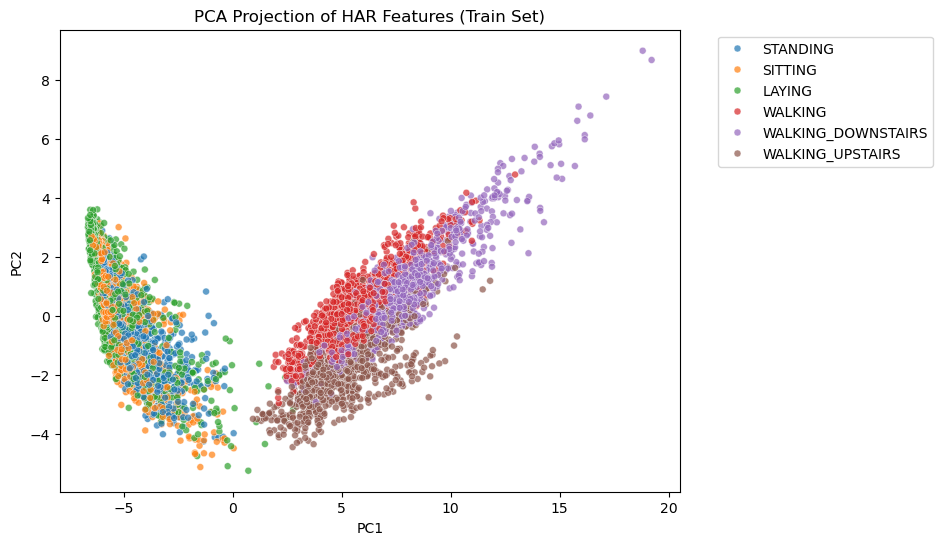

In [61]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

activity_labels = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}

pca = PCA(n_components=2)
X_proj = pca.fit_transform(X_train)

pca_df = pd.DataFrame({
    "PC1": X_proj[:, 0],
    "PC2": X_proj[:, 1],
    "Activity": y_train["Activity"].map(activity_labels)
})

plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Activity", palette="tab10", s=25, alpha=0.7)
plt.title("PCA Projection of HAR Features (Train Set)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### PCA Projection of HAR Features

Principal Component Analysis (PCA) was applied to reduce the high-dimensional HAR dataset (561 features) into just **two principal components (PC1 and PC2)** for visualization.  

- **Purpose**:  
  PCA captures the maximum variance in the data using fewer dimensions. This allows us to visualize high-dimensional data while retaining most of the original structure.  

- **Observations**:  
  - The scatterplot shows how different activities cluster when reduced to two dimensions.  
  - Some activities, such as **WALKING, WALKING_UPSTAIRS, and WALKING_DOWNSTAIRS**, appear relatively close to each other, which indicates potential overlap in their sensor signals.  
  - Others, like **SITTING, STANDING, and LAYING**, form clearer separations, reflecting distinct body acceleration/gyroscope patterns.  
  - The visualization confirms that even with just 2 dimensions, there is **meaningful separation** between activity classes, though some overlaps remain.  

- **Insight**:  
  While PCA helps us visualize the separability of activities, it is mainly a **linear dimensionality reduction** technique. Non-linear methods like **t-SNE or UMAP** may reveal more complex patterns. Nonetheless, PCA is valuable for identifying variance distribution and redundancy in features.  


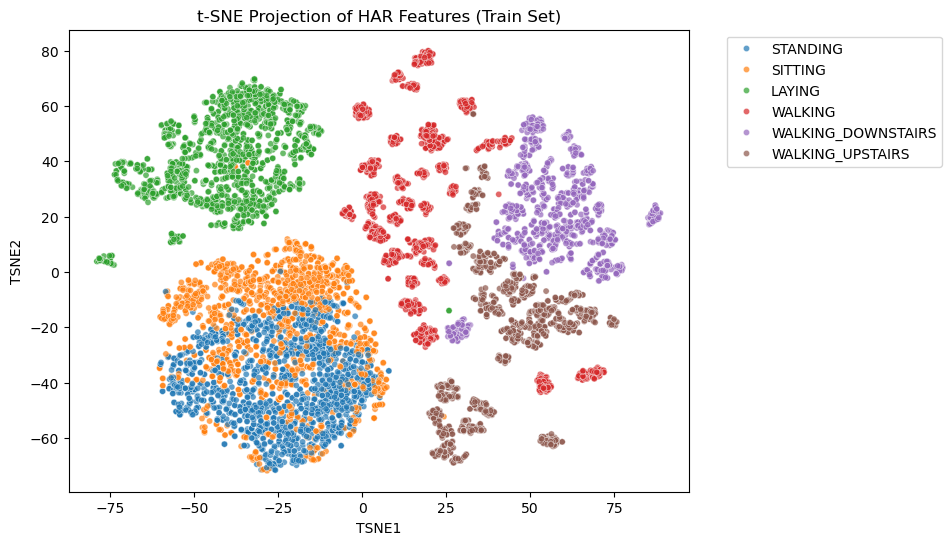

In [63]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_train)

tsne_df = pd.DataFrame({
    "TSNE1": X_tsne[:, 0],
    "TSNE2": X_tsne[:, 1],
    "Activity": y_train["Activity"].map({
        1: "WALKING",
        2: "WALKING_UPSTAIRS",
        3: "WALKING_DOWNSTAIRS",
        4: "SITTING",
        5: "STANDING",
        6: "LAYING"
    })
})

plt.figure(figsize=(8,6))
sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue="Activity", palette="tab10", s=20, alpha=0.7)
plt.title("t-SNE Projection of HAR Features (Train Set)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### t-SNE Projection of HAR Features

t-Distributed Stochastic Neighbor Embedding (t-SNE) was applied to the HAR dataset to reduce 561 features into **two dimensions** for visualization.  

- **Purpose**:  
  Unlike PCA, which is a **linear** dimensionality reduction method, t-SNE is a **non-linear technique** that focuses on preserving local neighborhood structures in high-dimensional data. This makes it especially effective for visualizing clusters.  

- **Observations**:  
  - The scatterplot shows clear clusters for different activities such as **STANDING, SITTING, and LAYING**, which form well-separated groups.  
  - Dynamic activities like **WALKING, WALKING_UPSTAIRS, and WALKING_DOWNSTAIRS** show partial overlap but still maintain distinguishable clusters.  
  - Compared to PCA, the clusters appear **more compact and separated**, reflecting the ability of t-SNE to uncover complex, non-linear patterns in the data.  

- **Insight**:  
  This visualization highlights that human activities have **distinct sensor signatures** captured by accelerometers and gyroscopes.  
  The separability shown by t-SNE supports the feasibility of applying machine learning models (including semi-supervised approaches) for accurate activity classification.  
